<a href="https://colab.research.google.com/github/otitamario/sp-pa-gep/blob/main/notebooks/Exp5_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Clone the repository into Colab runtime
!git clone https://github.com/otitamario/sp-pa-gep.git

# Move into repo root
%cd sp-pa-gep

# Make sure Python sees the project root
import sys
sys.path.append(".")

Cloning into 'sp-pa-gep'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 128 (delta 49), reused 55 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 1.78 MiB | 7.86 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/sp-pa-gep


SPPA final x: [ 2.51545564e-04  9.92880210e-01  1.98671726e+00 -9.93522133e-01] iters: 150
WPPA final x: [-1.38828667e-08  1.00000001e+00  2.00000001e+00 -9.99999990e-01] iters: 14
Known x*     : [ 0.  1.  2. -1.]
Saved: figures/exp5_6_residual.png


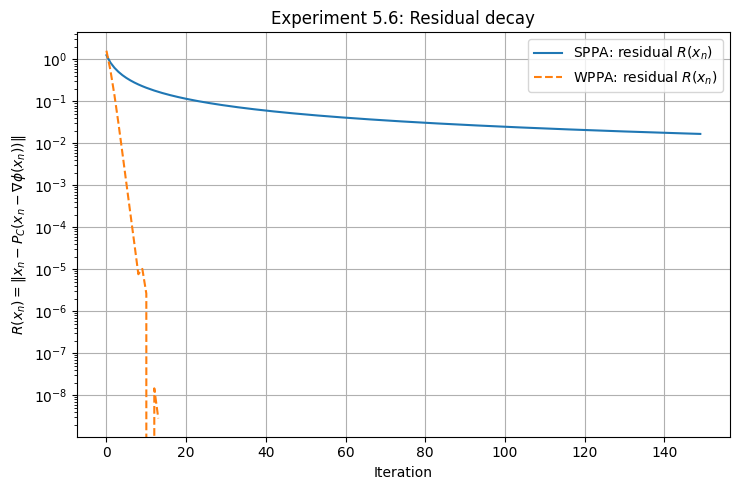

Saved: figures/exp5_6_error.png


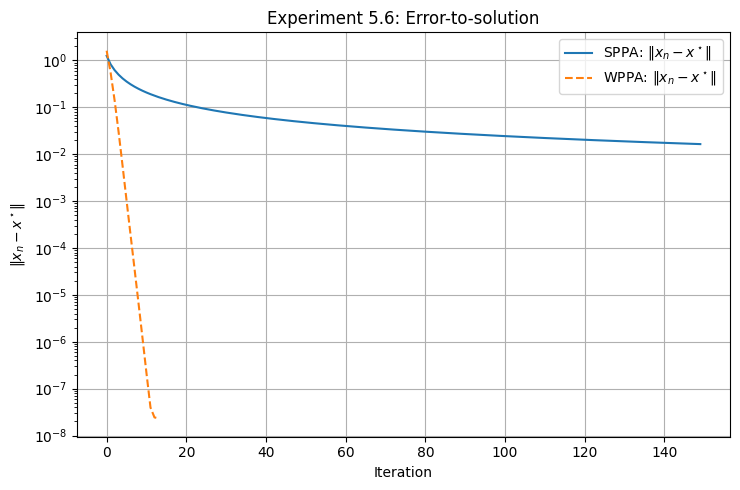

Saved: figures/exp5_6_steps.png


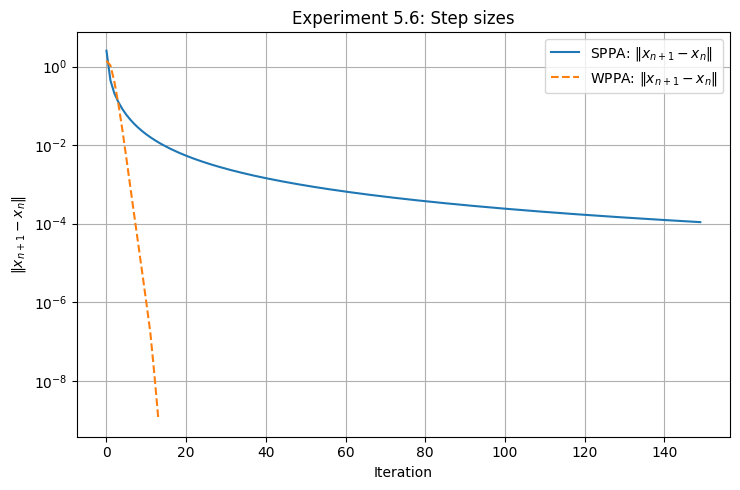


CPU / accuracy summary:
{'method': 'SPPA', 'iters': 150, 'total_s': 0.7983340660000522, 'avg_resolvent_s': 0.002886726460004259, 'avg_residual_s': 0.00240933332665918, 'final_err': 0.016405753186598288, 'final_residual': 0.01684858937189988}
{'method': 'WPPA', 'iters': 14, 'total_s': 0.05693913599998268, 'avg_resolvent_s': 0.0022838097857434798, 'avg_residual_s': 0.0017611841427976418, 'final_err': 2.3277028632408225e-08, 'final_residual': 2.8285036854870176e-09}

All figures saved under: figures/


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from time import perf_counter

# =========================
# OUTPUT DIRECTORY (save plots here)
# =========================
FIGDIR = "figures"
os.makedirs(FIGDIR, exist_ok=True)

# =========================
# Rosen–Suzuki data (Example 1)
# =========================
x_star = np.array([0.0, 1.0, 2.0, -1.0])

def phi(x):
    return (x[0]**2 + x[1]**2 + 2*x[2]**2 + x[3]**2
            - 5*x[0] - 5*x[1] - 21*x[2] + 7*x[3])

def grad_phi(x):
    return np.array([
        2*x[0] - 5,
        2*x[1] - 5,
        4*x[2] - 21,
        2*x[3] + 7
    ])

# Constraints in the form g_i(x) <= 0 (as in the paper)
def g1_raw(x):
    return x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 + x[0] - x[1] + x[2] - x[3] - 8

def g2_raw(x):
    return x[0]**2 + 2*x[1]**2 + x[2]**2 + 2*x[3]**2 - x[0] - x[3] - 10

def g3_raw(x):
    return 2*x[0]**2 + x[1]**2 + x[2]**2 + 2*x[0] - x[1] - x[3] - 5

# scipy 'ineq' expects c(x) >= 0, so use -g_i(x) >= 0

constraints = [
    {'type': 'ineq', 'fun': lambda x: -g1_raw(x),
     'jac': lambda x: -np.array([2*x[0]+1, 2*x[1]-1, 2*x[2]+1, 2*x[3]-1])},
    {'type': 'ineq', 'fun': lambda x: -g2_raw(x),
     'jac': lambda x: -np.array([2*x[0]-1, 4*x[1], 2*x[2], 4*x[3]-1])},
    {'type': 'ineq', 'fun': lambda x: -g3_raw(x),
     'jac': lambda x: -np.array([4*x[0]+2, 2*x[1]-1, 2*x[2], -1])},
]

# =========================
# Projection onto C
# =========================
def proj_C(z, x_init=None):
    """
    Best-effort projection onto C:
      P_C(z) = argmin_{y in C} 0.5||y-z||^2
    Returns (p, ok) where ok=True if some run reported success.
    """
    def obj(y):
        d = y - z
        return 0.5*np.dot(d, d)

    # candidate initial points
    inits = []
    if x_init is not None:
        inits.append(np.array(x_init, dtype=float))
    inits.append(np.array(z, dtype=float))
    inits.append(np.zeros(4, dtype=float))
    inits.append(x_star.copy())

    best = None
    best_val = np.inf
    any_success = False

    for init in inits:
        res = minimize(
            obj, init, method="SLSQP", constraints=constraints,
            options={"ftol": 1e-9, "maxiter": 1000}
        )
        y = res.x
        val = obj(y)
        if val < best_val:
            best_val = val
            best = y
        if res.success:
            any_success = True
            # return first success immediately (or keep searching if you prefer)
            return y, True

    return best, any_success
# Residual R(x) = ||x - P_C(x - grad phi(x))||
def residual_R(x):
    z = x - grad_phi(x)
    p, ok = proj_C(z, x_init=x)
    # Even if ok=False, we still compute a residual with best candidate p.
    return np.linalg.norm(x - p), ok
# =========================
# Resolvent for EP: u_n = argmin_{y in C} phi(y) + (1/(2r))||y - x_n||^2
# =========================
def resolvent(xn, r=1.0, x_init=None):
    def obj(y):
        d = y - xn
        return phi(y) + 0.5/r * np.dot(d, d)

    # candidate initial points (in order)
    inits = []
    if x_init is not None:
        inits.append(np.array(x_init, dtype=float))
    inits.append(np.array(xn, dtype=float))
    inits.append(np.zeros(4, dtype=float))   # usually feasible after projection
    inits.append(x_star.copy())              # known feasible optimum
    # also try projection of xn onto C
    pxn, ok_pxn = proj_C(xn, x_init=np.zeros(4))
    if ok_pxn:
        inits.append(pxn)

    best = None
    best_val = np.inf
    best_success = False

    for init in inits:
        res = minimize(
            obj, init, method="SLSQP", constraints=constraints,
            options={"ftol": 1e-9, "maxiter": 1000}  # relaxed ftol, more iters
        )
        y = res.x
        val = obj(y)
        if val < best_val:
            best_val = val
            best = y
            best_success = bool(res.success)

        if res.success:
            return y, True

    # If all failed, return best found but mark as False
    return best, False

# =========================
# SPPA / WPPA runners with logging
# =========================
def run_sppa(x0, u, r=1.0, maxit=120, tol_step=1e-8):
    x = x0.copy()
    xs = [x.copy()]
    step_sizes = []
    errs = []
    residuals = []
    t_resolvent = []
    t_residual = []

    t_total0 = perf_counter()
    last_un = x.copy()

    for k in range(maxit):
        alpha = 1.0/(k+2)

        # resolvent timing
        t0 = perf_counter()
        u_n, ok = resolvent(x, r=r, x_init=last_un)
        if not ok:
          print(f"[WARN] Resolvent SLSQP not successful at iter {k}; using best candidate.")

        t_resolvent.append(perf_counter() - t0)
        last_un = u_n.copy()

        x_new = alpha*u + (1.0-alpha)*u_n

        step = np.linalg.norm(x_new - x)
        step_sizes.append(step)
        errs.append(np.linalg.norm(x_new - x_star))

        # residual timing
        t0 = perf_counter()
        R, okR = residual_R(x_new)
        if not okR:
          print(f"[WARN] Residual projection not successful at iter {k}; using best candidate.")

        t_residual.append(perf_counter() - t0)
        residuals.append(R)

        xs.append(x_new.copy())

        if step <= tol_step:
            x = x_new
            break

        x = x_new

    t_total = perf_counter() - t_total0

    return {
        "x_final": x,
        "xs": np.array(xs),
        "step": np.array(step_sizes),
        "err": np.array(errs),
        "res": np.array(residuals),
        "t_resolvent": np.array(t_resolvent),
        "t_residual": np.array(t_residual),
        "t_total": t_total,
        "iters": len(step_sizes),
    }

def run_wppa(x0, r=1.0, maxit=120, tol_step=1e-8):
    x = x0.copy()
    xs = [x.copy()]
    step_sizes = []
    errs = []
    residuals = []
    t_resolvent = []
    t_residual = []

    t_total0 = perf_counter()
    last_un = x.copy()

    for k in range(maxit):
        alpha = 1.0/(k+2)

        # resolvent timing
        t0 = perf_counter()
        u_n, ok = resolvent(x, r=r, x_init=last_un)
        if not ok:
          print(f"[WARN] Resolvent SLSQP not successful at iter {k}; using best candidate.")

        t_resolvent.append(perf_counter() - t0)
        last_un = u_n.copy()

        x_new = alpha*x + (1.0-alpha)*u_n

        step = np.linalg.norm(x_new - x)
        step_sizes.append(step)
        errs.append(np.linalg.norm(x_new - x_star))

        # residual timing
        t0 = perf_counter()
        R, okR = residual_R(x_new)
        if not okR:
          print(f"[WARN] Residual projection not successful at iter {k}; using best candidate.")

        t_residual.append(perf_counter() - t0)
        residuals.append(R)

        xs.append(x_new.copy())

        if step <= tol_step:
            x = x_new
            break

        x = x_new

    t_total = perf_counter() - t_total0

    return {
        "x_final": x,
        "xs": np.array(xs),
        "step": np.array(step_sizes),
        "err": np.array(errs),
        "res": np.array(residuals),
        "t_resolvent": np.array(t_resolvent),
        "t_residual": np.array(t_residual),
        "t_total": t_total,
        "iters": len(step_sizes),
    }

# =========================
# Run + plots + CPU table
# =========================
# Choose a feasible-ish starting point; if unsure, project onto C first.
x0_guess = np.array([2.0, 2.0, 2.0, 2.0])
x0, _ = proj_C(x0_guess, x_init=np.zeros(4))
u = np.zeros(4)
r = 1.0

out_sppa = run_sppa(x0, u=u, r=r, maxit=150, tol_step=1e-8)
out_wppa = run_wppa(x0, r=r, maxit=150, tol_step=1e-8)

print("SPPA final x:", out_sppa["x_final"], "iters:", out_sppa["iters"])
print("WPPA final x:", out_wppa["x_final"], "iters:", out_wppa["iters"])
print("Known x*     :", x_star)

# ---- helper: save first, then show (prevents blank files in some notebooks) ----
def savefig(name):
    path = os.path.join(FIGDIR, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")

# =========================
# Plot 1: residuals (SAVE)
# =========================
plt.figure(figsize=(7.5, 5))
plt.semilogy(out_sppa["res"], label="SPPA: residual $R(x_n)$")
plt.semilogy(out_wppa["res"], linestyle="--", label="WPPA: residual $R(x_n)$")
plt.xlabel("Iteration")
plt.ylabel(r"$R(x_n)=\|x_n-P_C(x_n-\nabla\phi(x_n))\|$")
plt.title("Experiment 5.6: Residual decay")
plt.grid(True)
plt.legend()
plt.tight_layout()
savefig("exp5_6_residual.png")
plt.show()

# =========================
# Plot 2: error to solution (SAVE)
# =========================
plt.figure(figsize=(7.5, 5))
plt.semilogy(out_sppa["err"], label=r"SPPA: $\|x_n-x^\star\|$")
plt.semilogy(out_wppa["err"], linestyle="--", label=r"WPPA: $\|x_n-x^\star\|$")
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_n-x^\star\|$")
plt.title("Experiment 5.6: Error-to-solution")
plt.grid(True)
plt.legend()
plt.tight_layout()
savefig("exp5_6_error.png")
plt.show()

# =========================
# Plot 3: step sizes (SAVE)
# =========================
plt.figure(figsize=(7.5, 5))
plt.semilogy(out_sppa["step"], label=r"SPPA: $\|x_{n+1}-x_n\|$")
plt.semilogy(out_wppa["step"], linestyle="--", label=r"WPPA: $\|x_{n+1}-x_n\|$")
plt.xlabel("Iteration")
plt.ylabel(r"$\|x_{n+1}-x_n\|$")
plt.title("Experiment 5.6: Step sizes")
plt.grid(True)
plt.legend()
plt.tight_layout()
savefig("exp5_6_steps.png")
plt.show()

# =========================
# CPU comparison
# =========================
def cpu_summary(name, out):
    return {
        "method": name,
        "iters": out["iters"],
        "total_s": out["t_total"],
        "avg_resolvent_s": float(np.mean(out["t_resolvent"])) if len(out["t_resolvent"]) else np.nan,
        "avg_residual_s": float(np.mean(out["t_residual"])) if len(out["t_residual"]) else np.nan,
        "final_err": float(out["err"][-1]) if len(out["err"]) else np.nan,
        "final_residual": float(out["res"][-1]) if len(out["res"]) else np.nan,
    }

summ = [cpu_summary("SPPA", out_sppa), cpu_summary("WPPA", out_wppa)]
print("\nCPU / accuracy summary:")
for s in summ:
    print(s)

print(f"\nAll figures saved under: {FIGDIR}/")

In [9]:
# ─── 1. Configurar seu nome e email (só precisa rodar uma vez)
!git config --global user.name "otitamario"
!git config --global user.email "mario2013sj@gmail.com"

In [10]:
!git add .

In [11]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   figures/exp5_6_error.png
	modified:   figures/exp5_6_residual.png
	modified:   figures/exp5_6_steps.png



In [14]:
# ─── 2. Método mais seguro e prático (usando cache de credencial) ────────────────

from google.colab import userdata

# Salve o token como segredo no Colab (muito recomendado!)
# Vá na barra lateral esquerda → chave de cadeado "Secrets"
# Adicione um segredo chamado: GITHUB_TOKEN
# Cole seu token lá e marque "Notebook access"

token = userdata.get('GITHUB_TOKEN')          # pega o segredo
username = "otitamario"               # seu username
repo = "sp-pa-gep"              # ex: meu-projeto

# Configura o remote com o token (https)
!git remote set-url origin https://{token}@github.com/{username}/{repo}.git

# Ou se ainda não tem remote configurado:
#!git remote add origin https://{token}@github.com/{username}/{repo}.git

In [15]:
!git commit -m "exp 6"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [16]:
!git push origin main

Enumerating objects: 11, done.
Counting objects: 100% (11/11), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 278.73 KiB | 14.67 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/otitamario/sp-pa-gep.git
   dd46475..1ed1e2f  main -> main
